***

<h1>Содержание<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Подготовка" data-toc-modified-id="Подготовка-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Подготовка</a></span><ul class="toc-item"><li><span><a href="#Ресемприрование" data-toc-modified-id="Ресемприрование-1.1"><span class="toc-item-num">1.1&nbsp;&nbsp;</span>Ресемприрование</a></span></li></ul></li><li><span><a href="#Анализ" data-toc-modified-id="Анализ-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Анализ</a></span></li><li><span><a href="#Обучение" data-toc-modified-id="Обучение-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Обучение</a></span></li><li><span><a href="#Тестирование" data-toc-modified-id="Тестирование-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Тестирование</a></span></li><li><span><a href="#Чек-лист-проверки" data-toc-modified-id="Чек-лист-проверки-5"><span class="toc-item-num">5&nbsp;&nbsp;</span>Чек-лист проверки</a></span></li></ul></div>

#  Прогнозирование заказов такси

Компания «Чётенькое такси» собрала исторические данные о заказах такси в аэропортах. Чтобы привлекать больше водителей в период пиковой нагрузки, нужно спрогнозировать количество заказов такси на следующий час. Постройте модель для такого предсказания.

Значение метрики *RMSE* на тестовой выборке должно быть не больше 48.

Вам нужно:

1. Загрузить данные и выполнить их ресемплирование по одному часу.
2. Проанализировать данные.
3. Обучить разные модели с различными гиперпараметрами. Сделать тестовую выборку размером 10% от исходных данных.
4. Проверить данные на тестовой выборке и сделать выводы.


Данные лежат в файле `taxi.csv`. Количество заказов находится в столбце `num_orders` (от англ. *number of orders*, «число заказов»).

`Описание проекта:` в данном проекте мы будем исследовать периоды пика потребности в такси в целях лучшего прогнозирования спроса. Для этих целей, мы проведём ИАД и применим различные модели машинного обучения чтобы выявить лучшую модель для предсказания пикового спроса на такси в аэропорту.

## Подготовка

Имортируем библотеки согласно PEP-8

In [180]:
# стандартные библиотеки
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import seaborn as sns

# сторонние библиотеки
import catboost as cb
from catboost import CatBoostRegressor
from itertools import product
import lightgbm as lgb
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score
from sklearn.model_selection import TimeSeriesSplit, GridSearchCV
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle
from sklearn.preprocessing import OrdinalEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestRegressor
from sklearn.datasets import make_regression
from sklearn.metrics import r2_score
from sklearn.preprocessing import StandardScaler
from statsmodels.tsa.seasonal import seasonal_decompose

Загружаем библиотеки

In [181]:
try: 
    df = pd.read_csv('taxi.csv', index_col=[0], parse_dates=[0])
except: 
    df = pd.read_csv('/datasets/taxi.csv', index_col=[0], parse_dates=[0])

Создаём переменную для вывода информации о данных

In [182]:
def show_i(data):

    '''Выводим на экран следущую информацию:

    - размер таблицы
    - основную информацию
    - первые 5 строк таблицы
    - суммарная статистика по числовым параметрам
    '''

    display(data.shape)
    display(data.info())
    display(data.head())
    display(data.describe())
   

In [183]:
show_i(df)

(26496, 1)

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 26496 entries, 2018-03-01 00:00:00 to 2018-08-31 23:50:00
Data columns (total 1 columns):
 #   Column      Non-Null Count  Dtype
---  ------      --------------  -----
 0   num_orders  26496 non-null  int64
dtypes: int64(1)
memory usage: 414.0 KB


None

,num_orders
datetime,
2018-03-01 00:00:00,9
2018-03-01 00:10:00,14
2018-03-01 00:20:00,28
2018-03-01 00:30:00,20
2018-03-01 00:40:00,32


,num_orders
count,26496.000000
mean,14.070463
std,9.211330
min,0.000000
25%,8.000000
50%,13.000000
75%,19.000000
max,119.000000


`Вывод:` пропусков нет, максимальное кол-во заказов в день - 119, медианное значение - 13 заказов в день.

### Ресемприрование

До ресемплирования

In [184]:
df.head()

,num_orders
datetime,
2018-03-01 00:00:00,9
2018-03-01 00:10:00,14
2018-03-01 00:20:00,28
2018-03-01 00:30:00,20
2018-03-01 00:40:00,32


In [185]:
# ресемплируем данные по 1 ч. и округлим чтобы иметь дискретные значения на графике
df = df.resample('1H').mean().round()

Проверяем результат после ресемплирования

In [186]:
df.head()

,num_orders
datetime,
2018-03-01 00:00:00,21.0
2018-03-01 01:00:00,14.0
2018-03-01 02:00:00,12.0
2018-03-01 03:00:00,11.0
2018-03-01 04:00:00,7.0


In [187]:
show_i(df)

(4416, 1)

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 4416 entries, 2018-03-01 00:00:00 to 2018-08-31 23:00:00
Freq: H
Data columns (total 1 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   num_orders  4416 non-null   float64
dtypes: float64(1)
memory usage: 69.0 KB


None

,num_orders
datetime,
2018-03-01 00:00:00,21.0
2018-03-01 01:00:00,14.0
2018-03-01 02:00:00,12.0
2018-03-01 03:00:00,11.0
2018-03-01 04:00:00,7.0


,num_orders
count,4416.000000
mean,14.073370
std,7.513917
min,0.000000
25%,9.000000
50%,13.000000
75%,18.000000
max,77.000000


`Вывод:` установили дату в качестве индекса и провели ресемплирование по 1 ч. с округлением. Количество наблюдений (строк) в таблице ожидаемо уменшилось после ресемплирования.

## Анализ

Посмотрим на распределение заказов такси на временной шкале

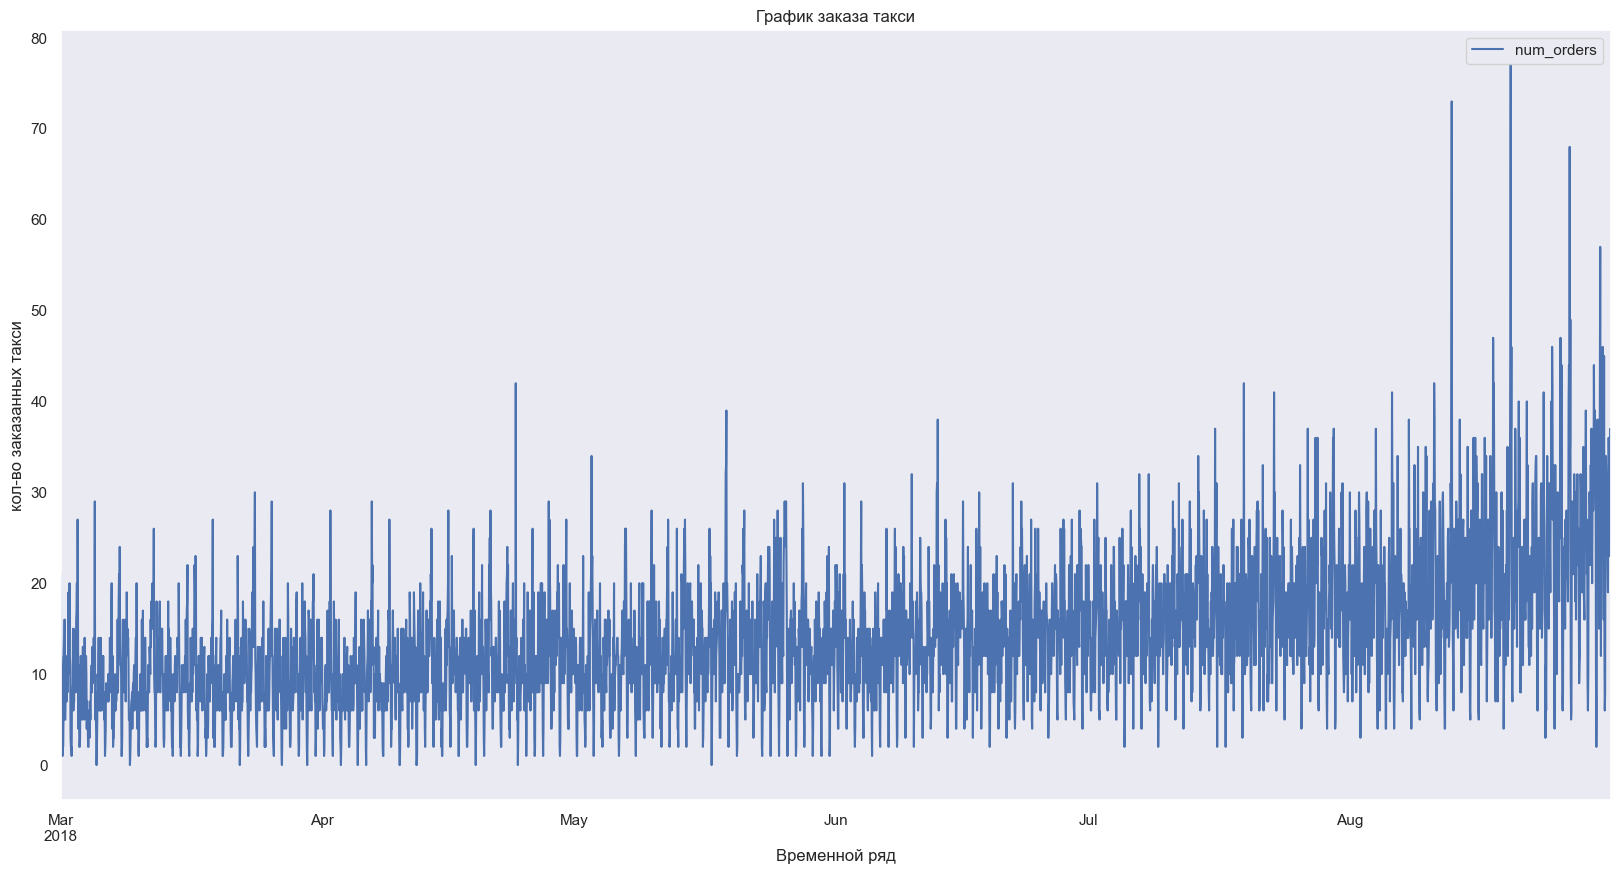

In [188]:
# задаём размеры графика
fig = plt.figure(figsize=(20, 10))

# создание графика
ax = fig.add_subplot(111)
df.plot(ax=ax)

# названия осей
plt.xlabel('Временной ряд')
plt.ylabel('кол-во заказанных такси')

# название графика
plt.title('График заказа такси')

# вывод графика
plt.show()

`Вывод:` мы видим, что заказы на такси растут после июня месяца, трудно судить о сезонности тк данные представленны не за весь календарный год, а только с марта по август 2018 г, для полноценной проверки сезонности нужно понаблюдать за несколькими циклами (годами) тем не менее тренд на увеличение заказов с июня налицо.

In [189]:
df.head(20)

,num_orders
datetime,
2018-03-01 00:00:00,21.0
2018-03-01 01:00:00,14.0
2018-03-01 02:00:00,12.0
2018-03-01 03:00:00,11.0
2018-03-01 04:00:00,7.0
2018-03-01 05:00:00,1.0
2018-03-01 06:00:00,2.0
2018-03-01 07:00:00,2.0
2018-03-01 08:00:00,6.0


<div class="alert alert-info"> <b>Комментарий студента:</b> Ограничил вывод 20-ю строками. </div>

Для более подробного анализа заказов, призовём стандартные ряды. Для этого найдём скользящее стандартное отклонение.

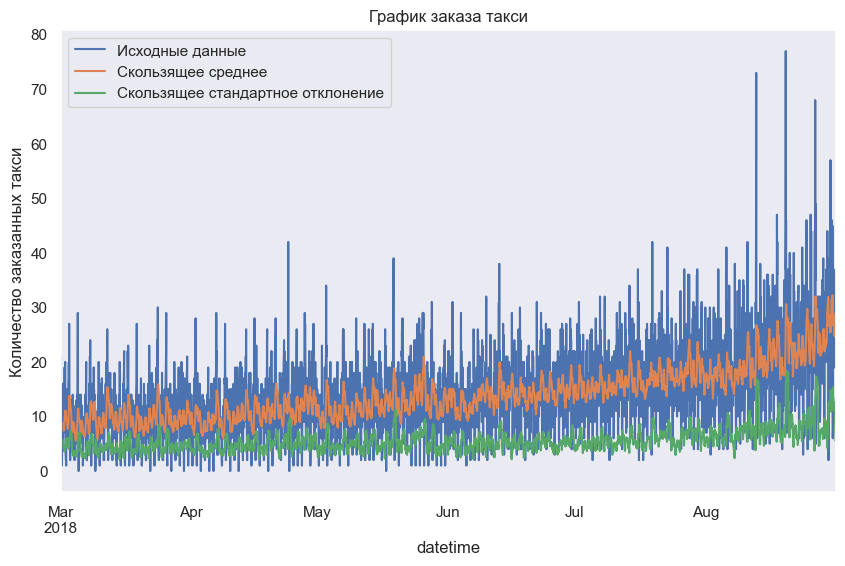

In [190]:
# устанавливаем размер графика
plt.figure(figsize=(10, 6))

# название графика
plt.title('График заказа такси')

# названия осей
plt.xlabel('Временной ряд')
plt.ylabel('Количество заказанных такси')

# созаём новые параметры
df2 = df.copy()
df2['mean'] = df['num_orders'].rolling(15).mean()
df2['std'] = df['num_orders'].rolling(15).std()
df2['num_orders'] = df['num_orders']

df2['num_orders'].plot(label='Исходные данные')
df2['mean'].plot(label='Скользящее среднее')
df2['std'].plot(label='Скользящее стандартное отклонение')

# выводим легенду
plt.legend()

# выводим график
plt.show()


`Вывод:` мы видим что график не является стационарным, скользящее среднее явно растёт. Скользящее стандартное отклонение тоже растёт, это ещё раз говорит о том что график нестационарный.

Проверим плотность значаний на графике

C:\Users\ASUS\AppData\Local\Temp\ipykernel_4448\3347675896.py:3: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(df)


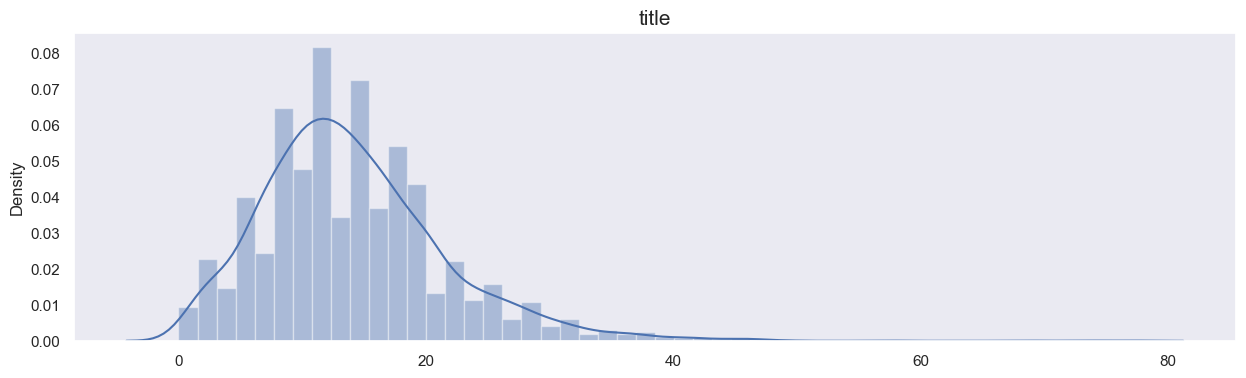

In [191]:
plt.figure(figsize=(15,4))
plt.title('title', fontsize=15)
sns.distplot(df)
sns.set(style='dark')
plt.show()

`Вывод:` мы видим что распределение имеет почти правильный нормальный вид (распределение Гаусса).

Посмотрим на выбросы

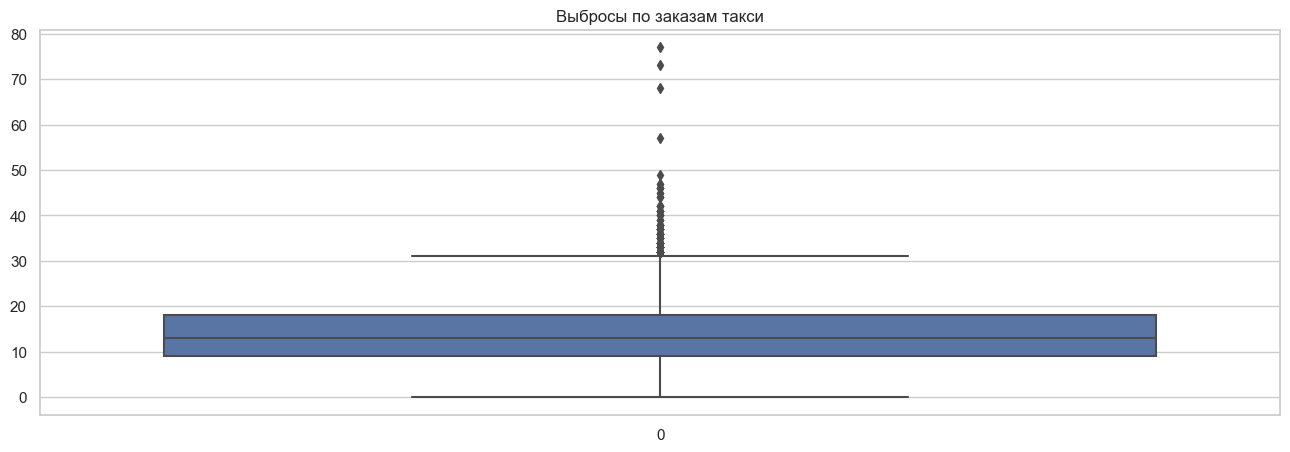

In [192]:
sns.set(style="whitegrid")
plt.figure(figsize=(16,5))
sns.boxplot(df.num_orders)
plt.title('Выбросы по заказам такси')
plt.show()

Посмотрим, а сколько значений выбиваются из общей картины

In [193]:
df.loc[df['num_orders'] > 50]

,num_orders
datetime,
2018-08-13 02:00:00,73.0
2018-08-20 02:00:00,77.0
2018-08-27 02:00:00,68.0
2018-08-30 17:00:00,57.0


Удалим четыре выбивающихся значения

In [194]:
df = df.loc[df['num_orders'] <= 50]

Проверяем, выбивающиеся значения удалены

In [195]:
df.loc[df['num_orders'] > 50]

,num_orders
datetime,


Посмотрим ещё раз на изменившийся график плотности

C:\Users\ASUS\AppData\Local\Temp\ipykernel_4448\3347675896.py:3: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(df)


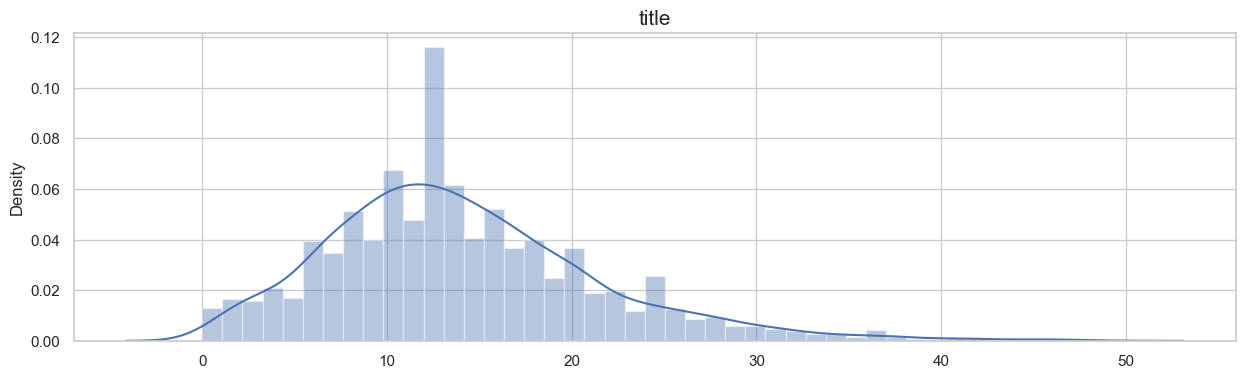

In [196]:
plt.figure(figsize=(15,4))
plt.title('title', fontsize=15)
sns.distplot(df)
sns.set(style='dark')
plt.show()

Декомпозиция

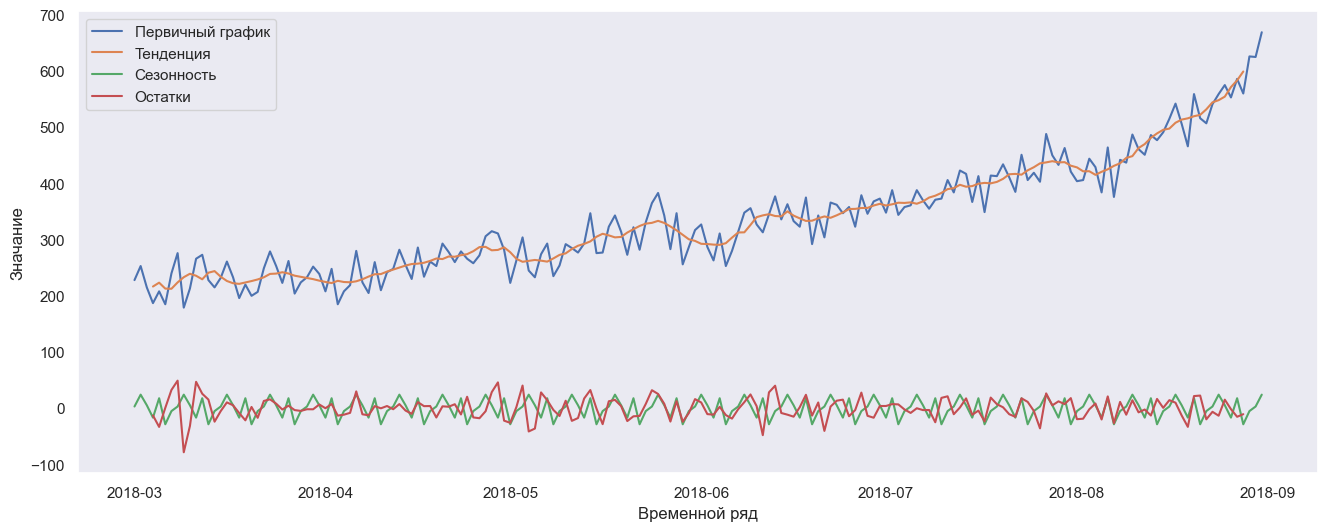

In [197]:
# делаем ресамплинг по дням
df_daily = df.resample('D').sum()

# проводим декомпозицию
decomposition = seasonal_decompose(df_daily, model='additive')

# сохраняем в переменные
trend = decomposition.trend
seasonal = decomposition.seasonal
residual = decomposition.resid

# выводим график первичную информацию, тренды, сезонность и остатки.
plt.figure(figsize=(16, 6))
plt.plot(df_daily, label='Первичный график')
plt.plot(trend, label='Тенденция')
plt.plot(seasonal, label='Сезонность')
plt.plot(residual, label='Остатки')


plt.xlabel('Временной ряд')
plt.ylabel('Значание')
plt.legend()
plt.show()

`Вывод:` несмотря на то, что выбивающиеся значения похожи на правду (видимо август это пик сезона, но не берёмся этого утверждать тк данные унас только за 5 месяцев), считаю нужным их удалить чтобы упростить обучение модели уменьшив шум.<br>

Новый график плотности стал более пологим без явных экстремальных значений

Наши данные готовы к обучению модели

***

## Обучение

Создадим доп. признаки для лучшей обучаемости моделей

In [198]:
def make_features(data, max_lag, rolling_mean_size):
    data['month'] = data.index.month
    data['day'] = data.index.day
    data['hour'] = data.index.hour
    data['dayofweek'] = data.index.dayofweek
    
    for lag in range(1, max_lag + 1):
        data['lag_{}'.format(lag)] = data['num_orders'].shift(lag)

    # < напишите код здесь >
    data['rolling_mean'] = data['num_orders'].shift().rolling(rolling_mean_size).mean()

In [199]:
make_features(df, 4, 4)
print(df.head())

                     num_orders  month  day  hour  dayofweek  lag_1  lag_2  \
datetime                                                                     
2018-03-01 00:00:00        21.0      3    1     0          3    NaN    NaN   
2018-03-01 01:00:00        14.0      3    1     1          3   21.0    NaN   
2018-03-01 02:00:00        12.0      3    1     2          3   14.0   21.0   
2018-03-01 03:00:00        11.0      3    1     3          3   12.0   14.0   
2018-03-01 04:00:00         7.0      3    1     4          3   11.0   12.0   

                     lag_3  lag_4  rolling_mean  
datetime                                         
2018-03-01 00:00:00    NaN    NaN           NaN  
2018-03-01 01:00:00    NaN    NaN           NaN  
2018-03-01 02:00:00    NaN    NaN           NaN  
2018-03-01 03:00:00   21.0    NaN           NaN  
2018-03-01 04:00:00   14.0   21.0          14.5  


C:\Users\ASUS\AppData\Local\Temp\ipykernel_4448\1818613298.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['month'] = data.index.month
C:\Users\ASUS\AppData\Local\Temp\ipykernel_4448\1818613298.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['day'] = data.index.day
C:\Users\ASUS\AppData\Local\Temp\ipykernel_4448\1818613298.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveat

In [200]:
df.head(20)

,num_orders,month,day,hour,dayofweek,lag_1,lag_2,lag_3,lag_4,rolling_mean
datetime,,,,,,,,,,
2018-03-01 00:00:00,21.0,3,1,0,3,NaN,NaN,NaN,NaN,NaN
2018-03-01 01:00:00,14.0,3,1,1,3,21.0,NaN,NaN,NaN,NaN
2018-03-01 02:00:00,12.0,3,1,2,3,14.0,21.0,NaN,NaN,NaN
2018-03-01 03:00:00,11.0,3,1,3,3,12.0,14.0,21.0,NaN,NaN
2018-03-01 04:00:00,7.0,3,1,4,3,11.0,12.0,14.0,21.0,14.50
2018-03-01 05:00:00,1.0,3,1,5,3,7.0,11.0,12.0,14.0,11.00
2018-03-01 06:00:00,2.0,3,1,6,3,1.0,7.0,11.0,12.0,7.75
2018-03-01 07:00:00,2.0,3,1,7,3,2.0,1.0,7.0,11.0,5.25
2018-03-01 08:00:00,6.0,3,1,8,3,2.0,2.0,1.0,7.0,3.00


Для начала, разделим данные на выборки удаляя пропуски

In [201]:
train, test = train_test_split(df.dropna(), shuffle=False, test_size=0.1)


print(train.index.min(), train.index.max())
print(test.index.min(), test.index.max())

2018-03-01 04:00:00 2018-08-13 11:00:00
2018-08-13 12:00:00 2018-08-31 23:00:00


`Наблюдение:` тк на тестовую выборку приходиться период с середины по конец августа, когда наблюдается нехарактерный для начала года рост заказов, предположу что обучающая выборка недостаточно репрезентативна для качественного предсказания тестовой выборки из-за разницы в трендах между 2018-03-01 00:00:00 2018-08-13 10:00:00 и 2018-08-13 11:00:00 2018-08-31 23:00:00

In [202]:
features_train = train.drop('num_orders', axis = 1)
target_train = train['num_orders']

In [203]:
features_test = test.drop('num_orders', axis = 1)
target_test = test['num_orders']

In [204]:
print(features_train.shape)
print(features_test.shape)
print(target_train.shape)
print(target_test.shape)

(3967, 9)
(441, 9)
(3967,)
(441,)


Обучим нашу первую модель - Случайный лес

Random Forest

In [205]:
%%time
param_grid = {
    'n_estimators': np.arange(100, 1000, 100),
    'max_depth': [None, 5, 10, 20],
    'min_samples_split': np.arange(2, 20, 2),
    'min_samples_leaf': np.arange(1, 10, 1),
    'max_features': ['sqrt', 'log2', None]
}

# сохраняем в переменную модель случайного леса
estimator = RandomForestRegressor(random_state=12345)

# создаём кросс-валидацию TimeSeriesSplit
tscv = TimeSeriesSplit(n_splits=5)

# делаем перебор параметров и проводим кросс-валидацию
random_search = RandomizedSearchCV(estimator, param_grid, scoring='neg_root_mean_squared_error', n_iter=10, cv=tscv, random_state=12345)
random_search.fit(features_train, target_train)

# сохраняем предсказания модели в переменную
predictions = random_search.best_estimator_.predict(features_test)

# выводим лучшую модель и лучшую метрику
print("Best estimator:", random_search.best_estimator_)
print("RMSE:", -random_search.best_score_)

Best estimator: RandomForestRegressor(max_features=None, min_samples_leaf=9,
                      min_samples_split=16, n_estimators=900,
                      random_state=12345)
RMSE: 4.206372715720972
CPU times: total: 1min 48s
Wall time: 1min 49s


CatBoost

In [206]:
%%time

# задаём параметры и сохраняем модель в переменную
model_CBR = CatBoostRegressor()
parameters = {'depth': [6,8,10],
              'learning_rate': [0.01, 0.05, 0.1],
              'iterations': [30, 50, 100],
              'l2_leaf_reg': [0.2, 0.5, 1, 3]
             }
# создаём кросс-валидацию TimeSeriesSplit
tscv = TimeSeriesSplit(n_splits=5)

# производим перебор параметров и обучение модели
grid = GridSearchCV(estimator=model_CBR, param_grid = parameters, scoring='neg_root_mean_squared_error', cv = tscv, n_jobs=-1)
grid.fit(features_train, target_train)

# выводим лучшие параметры и метрику RMSE
print("RMSE:", -grid.best_score_)
print("Best parameters:", grid.best_params_)

0:	learn: 6.0641411	total: 2.08ms	remaining: 206ms
1:	learn: 5.8011302	total: 4.5ms	remaining: 221ms
2:	learn: 5.6214158	total: 6.11ms	remaining: 198ms
3:	learn: 5.4341142	total: 7.55ms	remaining: 181ms
4:	learn: 5.2473265	total: 9.01ms	remaining: 171ms
5:	learn: 5.0907380	total: 10.5ms	remaining: 164ms
6:	learn: 4.9471378	total: 12ms	remaining: 160ms
7:	learn: 4.8438482	total: 13.4ms	remaining: 154ms
8:	learn: 4.7250172	total: 14.8ms	remaining: 150ms
9:	learn: 4.6291999	total: 16.3ms	remaining: 146ms
10:	learn: 4.5562288	total: 17.7ms	remaining: 143ms
11:	learn: 4.4811796	total: 19.6ms	remaining: 143ms
12:	learn: 4.4045660	total: 21.1ms	remaining: 141ms
13:	learn: 4.3540638	total: 22.5ms	remaining: 138ms
14:	learn: 4.3066060	total: 23.9ms	remaining: 136ms
15:	learn: 4.2579950	total: 25.4ms	remaining: 133ms
16:	learn: 4.2144922	total: 26.8ms	remaining: 131ms
17:	learn: 4.1865966	total: 28.2ms	remaining: 128ms
18:	learn: 4.1474148	total: 29.6ms	remaining: 126ms
19:	learn: 4.1174004	tota

LGBM Regressor

In [207]:
%%time

# задаём параметры
params = {
    'objective': ['regression'],
    'metric': ['rmse'],
    'boosting_type': ['gbdt'],
    'num_leaves': range(90, 128),
    'learning_rate': [0.05],
    'feature_fraction': [0.9],
    'reg_alpha': [0.1, 0.2, 0.3, 0.4, 0.5],
    'min_data_in_leaf': [30, 50, 300]
}

# сохраняем модель в переменную
model = lgb.LGBMRegressor()

# создаём кросс-валидацию TimeSeriesSplit
tscv = TimeSeriesSplit(n_splits=5)

# производим перебор параметров и обучение модели
grid_search = GridSearchCV(model, params, cv=tscv, scoring='neg_root_mean_squared_error')
grid_search.fit(features_train, target_train)

# выводим лучшие параметры и метрику RMSE
print('Best parameters:', grid_search.best_params_)
print('RMSE score:', -grid_search.best_score_)

[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] min_data_in_leaf is set=30, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=30
[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] min_data_in_leaf is set=30, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=30
[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] min_data_in_leaf is set=30, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=30
[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] min_data_in_leaf is set=30, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=30
[LightGBM] [Warn

|Модель                |RMSE                                   |Время обучения      
|---                   |---                                    |---                
|Random Forest         |4.206372715720972                      |1min 49s
|CatBoost              |4.181504197449546                      |1min 42s     
|LightGBM              |4.11322324752283                       |2min 42s

`Вывод:` лучшей моделью с наименьшей RMSE показала себя - LGBM Regressor (RMSE score: 4.11322324752283)

## Тестирование

На тестовой выборке мы проверим LGBM Regressor которая показала себу лучше всех. 

In [208]:
%%time

# задаём параметры
params = {
    'objective': ['regression'],
    'metric': ['rmse'],
    'boosting_type': ['gbdt'],
    'num_leaves': range(90),
    'learning_rate': [0.05],
    'feature_fraction': [0.9],
    'reg_alpha': [0.2],
    'min_data_in_leaf': [30]
}


# сохраняем модель в переменную
model = lgb.LGBMRegressor()

# создаём кросс-валидацию TimeSeriesSplit
tscv = TimeSeriesSplit(n_splits=5)

# производим перебор параметров и обучение модели
grid_search = GridSearchCV(model, params, cv=tscv, scoring='neg_root_mean_squared_error')
grid_search.fit(features_test, target_test)

# выводим лучшие параметры и метрику RMSE
print('Best parameters:', grid_search.best_params_)
print('RMSE score:', -grid_search.best_score_)

[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] min_data_in_leaf is set=30, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=30
[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] min_data_in_leaf is set=30, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=30
[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] min_data_in_leaf is set=30, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=30
[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] min_data_in_leaf is set=30, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=30
[LightGBM] [Warn

c:\Users\ASUS\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:378: FitFailedWarning: 
10 fits failed out of a total of 450.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
10 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\ASUS\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 686, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\ASUS\anaconda3\lib\site-packages\lightgbm\sklearn.py", line 895, in fit
    super().fit(X, y, sample_weight=sample_weight, init_score=init_score,
  File "c:\Users\ASUS\anaconda3\lib\site-packages\lightgbm\sklearn.py", line 748, in fit
    self._Booster = train(
  File "c:\Users\ASUS\anaconda3\

`Вывод:` тестовая модель показала хороший результат. Моё наблюдение (сделанное после разделения выброк) о возможной неточности в предсказаниях из-за недостаточной репрезентативности не оправдалось.<br>

Модель LGBM Regressor показала RMSE score: 6.895903172746502 что намного мешьше необходимого согласно заданию (RMSE score: 48)

`Общий вывод:` В результате проведённого исследования, была всестаронне изучена и проаналиирована информация о размещении заказов такси с период с начала марта 2018 г. до конца августа 2018 г.

Построение графика временного ряда выявило, что график не является стационарным, скользящее среднее явно растёт. Скользящее стандартное отклонение тоже растёт, это ещё раз говорит о том что график нестационарный.

Распределение плотности заказов показало что распределение имеет почти правильный нормальный вид (распределение Гаусса).

Было выявлено 4 выброса которые я решил удалить для уменьшения шума при обучении модели при этом не в ущерб качеству обучения.

В результате удаления выбросов новый график плотности стал более пологим без явных экстремальных значений.

Для предсказания кол-ва заказов в зависимости от даты, было обучено три модели: RF, CatBoost и LBGM. Лучшей оказалась LGBM, она и была применена на тестовых данных которы составляли 10% от исходных данных.


|Модель                |RMSE                                   |Время обучения      
|---                   |---                                    |---                
|Random Forest         |4.206372715720972                      |1min 49s
|CatBoost              |4.181504197449546                      |1min 42s     
|LightGBM              |4.11322324752283                       |2min 42s

`Метрика RMSE на тестовой выборке - RMSE score: 6.895903172746502  < 48`


***